In [58]:
# Data processing
# ==============================================================================
import numpy as np
import pandas as pd

# Plots
# ==============================================================================
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
import plotly.express as px
plt.style.use('fivethirtyeight')
plt.rcParams['lines.linewidth'] = 1.5
%matplotlib inline

# Modelling and Forecasting
# ==============================================================================
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor

from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import make_pipeline

from skforecast.ForecasterAutoreg import ForecasterAutoreg
from skforecast.ForecasterAutoregMultiOutput import ForecasterAutoregMultiOutput
from skforecast.model_selection import grid_search_forecaster
from skforecast.model_selection import backtesting_forecaster

from joblib import dump, load

In [59]:
#Reading in data
# ==============================================================================
building0=pd.read_csv('Building0.csv')

In [62]:
#Converting to Datetime objects
# ==============================================================================
building0['datetime']=pd.to_datetime(building0['datetime'], format='%d/%m/%Y %H:%M')
building0= building0.set_index('datetime')
building0= building0.asfreq('H')

In [142]:
building0

,X,Unnamed..0,series_name,Year,Month,Day_of_Month,Week,Day,Hour,series_value,NumericMonth
datetime,,,,,,,,,,,
2016-07-04 07:00:00,0.0,0.0,Building0,2016.0,Jul,4.0,27.0,1.0,7.0,283.800,7.0
2016-07-04 08:00:00,1.0,1.0,Building0,2016.0,Jul,4.0,27.0,1.0,8.0,525.450,7.0
2016-07-04 09:00:00,2.0,2.0,Building0,2016.0,Jul,4.0,27.0,1.0,9.0,381.000,7.0
2016-07-04 10:00:00,3.0,3.0,Building0,2016.0,Jul,4.0,27.0,1.0,10.0,314.850,7.0
2016-07-04 11:00:00,4.0,4.0,Building0,2016.0,Jul,4.0,27.0,1.0,11.0,305.050,7.0
...,...,...,...,...,...,...,...,...,...,...,...
2020-10-01 05:00:00,37194.0,37194.0,Building0,2020.0,Oct,1.0,40.0,4.0,5.0,155.075,10.0
2020-10-01 06:00:00,37195.0,37195.0,Building0,2020.0,Oct,1.0,40.0,4.0,6.0,160.575,10.0
2020-10-01 07:00:00,37196.0,37196.0,Building0,2020.0,Oct,1.0,40.0,4.0,7.0,147.450,10.0


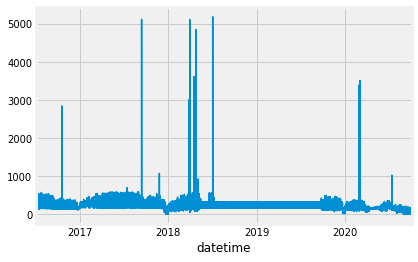

In [141]:
building0['series_value'].plot()

In [83]:
#Further Split Train-Val for Buildings
# ==============================================================================
end_train='2018-12-31 23:00'
start_val='2019-01-01 00:00'
end_val='2019-12-31 23:00'
start_test='2020-01-01 00:00'


building0train=building0.loc[:end_train, :]
building0val=building0.loc[start_val:end_val, :]
building0test=building0.loc[start_test:, :]

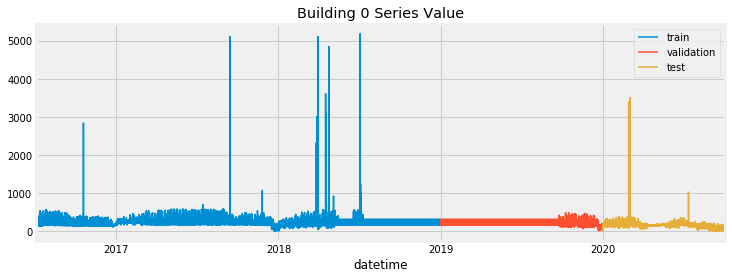

In [84]:
# Plot time series
# ==============================================================================
fig, ax = plt.subplots(figsize=(11, 4))
building0train['series_value'].plot(ax=ax, label='train')
building0val['series_value'].plot(ax=ax, label='validation')
building0test['series_value'].plot(ax=ax, label='test')
ax.set_title('Building 0 Series Value')
ax.legend();

In [85]:
building0train

,X,Unnamed..0,series_name,Year,Month,Day_of_Month,Week,Day,Hour,series_value,NumericMonth
datetime,,,,,,,,,,,
2016-07-04 07:00:00,0.0,0.0,Building0,2016.0,Jul,4.0,27.0,1.0,7.0,283.800000,7.0
2016-07-04 08:00:00,1.0,1.0,Building0,2016.0,Jul,4.0,27.0,1.0,8.0,525.450000,7.0
2016-07-04 09:00:00,2.0,2.0,Building0,2016.0,Jul,4.0,27.0,1.0,9.0,381.000000,7.0
2016-07-04 10:00:00,3.0,3.0,Building0,2016.0,Jul,4.0,27.0,1.0,10.0,314.850000,7.0
2016-07-04 11:00:00,4.0,4.0,Building0,2016.0,Jul,4.0,27.0,1.0,11.0,305.050000,7.0
...,...,...,...,...,...,...,...,...,...,...,...
2018-12-31 19:00:00,21849.0,21849.0,Building0,2018.0,Dec,31.0,53.0,1.0,19.0,290.733751,12.0
2018-12-31 20:00:00,21850.0,21850.0,Building0,2018.0,Dec,31.0,53.0,1.0,20.0,316.758776,12.0
2018-12-31 21:00:00,21851.0,21851.0,Building0,2018.0,Dec,31.0,53.0,1.0,21.0,314.276900,12.0


In [86]:
building0val

,X,Unnamed..0,series_name,Year,Month,Day_of_Month,Week,Day,Hour,series_value,NumericMonth
datetime,,,,,,,,,,,
2019-01-01 00:00:00,21878.0,21878.0,Building0,2019.0,Jan,1.0,1.0,2.0,0.0,185.271966,1.0
2019-01-01 01:00:00,21879.0,21879.0,Building0,2019.0,Jan,1.0,1.0,2.0,1.0,175.629525,1.0
2019-01-01 02:00:00,21880.0,21880.0,Building0,2019.0,Jan,1.0,1.0,2.0,2.0,171.823199,1.0
2019-01-01 03:00:00,21881.0,21881.0,Building0,2019.0,Jan,1.0,1.0,2.0,3.0,170.161277,1.0
2019-01-01 04:00:00,21882.0,21882.0,Building0,2019.0,Jan,1.0,1.0,2.0,4.0,182.565750,1.0
...,...,...,...,...,...,...,...,...,...,...,...
2019-12-31 19:00:00,30608.0,30608.0,Building0,2019.0,Dec,31.0,53.0,2.0,19.0,122.300000,12.0
2019-12-31 20:00:00,30609.0,30609.0,Building0,2019.0,Dec,31.0,53.0,2.0,20.0,144.300000,12.0
2019-12-31 21:00:00,30610.0,30610.0,Building0,2019.0,Dec,31.0,53.0,2.0,21.0,154.650000,12.0


In [122]:
# Create forecaster
# ==============================================================================
forecaster = ForecasterAutoreg(
                regressor = LGBMRegressor(random_state=123),
                lags = 24
                )

forecaster

ForecasterAutoreg 
Regressor: LGBMRegressor(random_state=123) 
Lags: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24] 
Window size: 24 
Included exogenous: False 
Type of exogenous variable: None 
Exogenous variables names: None 
Training range: None 
Training index type: None 
Training index frequency: None 
Regressor parameters: {'boosting_type': 'gbdt', 'class_weight': None, 'colsample_bytree': 1.0, 'importance_type': 'split', 'learning_rate': 0.1, 'max_depth': -1, 'min_child_samples': 20, 'min_child_weight': 0.001, 'min_split_gain': 0.0, 'n_estimators': 100, 'n_jobs': -1, 'num_leaves': 31, 'objective': None, 'random_state': 123, 'reg_alpha': 0.0, 'reg_lambda': 0.0, 'silent': 'warn', 'subsample': 1.0, 'subsample_for_bin': 200000, 'subsample_freq': 0} 
Creation date: 2022-09-20 00:22:53 
Last fit date: None 
Skforecast version: 0.4.3 

In [123]:
# Grid search of hyperparameters and lags
# ==============================================================================
# Regressor hyperparameters

param_grid = {
    'n_estimators': [100, 500],
    'max_depth': [3, 5, 10],
    'learning_rate': [0.01, 0.1]
    }
lags_grid = [24, 48, 72, [1, 2, 3, 23, 24, 25, 71, 72, 73]]

results_grid = grid_search_forecaster(
                        forecaster         = forecaster,
                        y                  = building0.loc[:end_val, 'series_value'],
                        metric             = 'mean_squared_error',
                        initial_train_size = int(len(building0train)),
                        lags_grid          = lags_grid,
                        param_grid         = param_grid,
                        steps              = 36,
                        )

Number of models compared: 48


loop lags_grid:   0%|                                               | 0/4 [00:00<?, ?it/s]


Exception: `y` has missing values.

In [90]:
len(building0.loc[:val_end])

30617

In [91]:
int(len(building0train))

21857

In [92]:
building0.loc[:end_val, 'series_value']

datetime
2016-07-04 07:00:00    283.800
2016-07-04 08:00:00    525.450
2016-07-04 09:00:00    381.000
2016-07-04 10:00:00    314.850
2016-07-04 11:00:00    305.050
                        ...   
2019-12-31 19:00:00    122.300
2019-12-31 20:00:00    144.300
2019-12-31 21:00:00    154.650
2019-12-31 22:00:00    165.875
2019-12-31 23:00:00    163.750
Freq: H, Name: series_value, Length: 30617, dtype: float64

In [93]:
len(building0train)+len(building0val)

30617

In [125]:
building0['series_value'].isnull().sum()

4

In [132]:
building3['series_value'].isnull().sum()
        

0

In [134]:
building0

,X,Unnamed..0,series_name,Year,Month,Day_of_Month,Week,Day,Hour,series_value,NumericMonth
datetime,,,,,,,,,,,
2016-07-04 07:00:00,0.0,0.0,Building0,2016.0,Jul,4.0,27.0,1.0,7.0,283.800,7.0
2016-07-04 08:00:00,1.0,1.0,Building0,2016.0,Jul,4.0,27.0,1.0,8.0,525.450,7.0
2016-07-04 09:00:00,2.0,2.0,Building0,2016.0,Jul,4.0,27.0,1.0,9.0,381.000,7.0
2016-07-04 10:00:00,3.0,3.0,Building0,2016.0,Jul,4.0,27.0,1.0,10.0,314.850,7.0
2016-07-04 11:00:00,4.0,4.0,Building0,2016.0,Jul,4.0,27.0,1.0,11.0,305.050,7.0
...,...,...,...,...,...,...,...,...,...,...,...
2020-10-01 05:00:00,37194.0,37194.0,Building0,2020.0,Oct,1.0,40.0,4.0,5.0,155.075,10.0
2020-10-01 06:00:00,37195.0,37195.0,Building0,2020.0,Oct,1.0,40.0,4.0,6.0,160.575,10.0
2020-10-01 07:00:00,37196.0,37196.0,Building0,2020.0,Oct,1.0,40.0,4.0,7.0,147.450,10.0


In [133]:
building0[building0['series_value'].isna()]

,X,Unnamed..0,series_name,Year,Month,Day_of_Month,Week,Day,Hour,series_value,NumericMonth
datetime,,,,,,,,,,,
2016-10-02 02:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2017-10-01 02:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-10-07 02:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2019-10-06 02:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [135]:
# Backtesting
# ==============================================================================
metric, predictions = backtesting_forecaster(
    forecaster = forecaster,
    y          = data['users'],
    initial_train_size = len(data.loc[:end_validation]),
    fixed_train_size   = False,
    steps      = 36,
    refit      = False,
    metric     = 'mean_squared_error',
    verbose    = False # Change to True to see detailed information
    )

print(f"Backtest error: {metric}")

NameError: name 'data' is not defined

In [137]:
# Predictions
# ==============================================================================
predictions

NameError: name 'predictions' is not defined

In [ ]:
# Plot of predictions
# ==============================================================================
fig, ax = plt.subplots(figsize=(11, 4))
data_test['users'].plot(ax=ax, label='test')
predictions['pred'].plot(ax=ax, label='predictions')
ax.legend();